In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_dda = pd.read_table('proteinGroups_dda.txt', delimiter = "\t")
df_dia_lib_mod = pd.read_table('LibraryModeProteinGroups_dia.txt', delimiter = "\t")
df_dia_disc_mod = pd.read_table('DiscoveryModeProteinGroups_dia.txt', delimiter = "\t")

In [5]:
def get_table(df):
    intensity = df.filter(like='LFQ intensity ')#filter from “outliers”
    intensity = intensity.replace(0, np.nan)
    intensity = intensity.applymap(lambda x: np.log(x))
    average_intens = pd.DataFrame({'mean':intensity.mean(axis = 1, skipna = True)})
    intensity = intensity.join(average_intens)
    intensity = pd.DataFrame(df['Majority protein IDs']).join(intensity)
    rank = [i for i in range (1, intensity.shape[0]+1)]
    new_df = pd.DataFrame({'rank': rank})
    intensity = intensity.sort_values(by = 'mean',ascending=False).reset_index(drop=True)
    intensity = new_df.join(intensity)
    return intensity

In [6]:
def row_check(table1, row2):
    counter = 0#counter of rows in new table
    buf2 =""#buffer for rows in big table
    for row1 in table1['Majority Protein IDs']:   
        buf1 = ""#buffer of rows in small table
        
        for char1 in row1:
            if char1!=';':
                buf1 = buf1+char1
            else:
                    buf2 = ""
                    for char2 in row2:
                        if char2!= ';':
                            buf2 = buf2+char2
                        else:
                            if buf2==buf1:
                                return counter
                            buf2 = ""
                    if buf2==buf1:
                        return counter
                    
                    buf1 = ""
                    buf2 = ""
                    
        for char2 in row2:
            if char2!=';':
                buf2=buf2+char2
            else:
                if buf2==buf1:
                    return counter
                buf2 = ""
        if buf2==buf1:
            return counter
        buf1 = ""
        buf2 = ""
        counter = counter+1
    return None
def table_parser(table1, table2):
    buf = ""
    table1 = table1[table1['FDA-approved Biomarker']=='+'].reset_index(drop=True)
    table2 = table2.join(pd.DataFrame({'FDA-approved Biomarker':[],'Act in Plasma ': [],'Tissue Leakage ':[], 'Receptor Ligands':[]}, dtype = str))
    counter = 0
    for row2 in table2['Majority protein IDs']:
        res = row_check(table1, row2)
        if res!=None:
            table2.loc[counter,'Act in Plasma '] = table1.loc[res, 'Act in Plasma ']
            table2.loc[counter,'Tissue Leakage '] = table1.loc[res, 'Tissue Leakage ']
            table2.loc[counter,'Receptor Ligands'] = table1.loc[res, 'Receptor Ligands']
            table2.loc[counter,'FDA-approved Biomarker'] = table1.loc[res, 'FDA-approved Biomarker']
        counter = counter+1
    res = table2[table2['FDA-approved Biomarker']=='+']
    return res

In [7]:
def plot_biomarker(intensity, title, get_df):
    fig, ax = plt.subplots()
    g4 = ax.scatter(get_df['rank'], get_df['mean'],color = 'grey')
    #plt.legend([g])
    g2 = ax.scatter(intensity[intensity['Act in Plasma ']=='+']['rank'], intensity[intensity['Act in Plasma ']=='+']['mean'],color = 'orange')
    g3 = ax.scatter(intensity[intensity['Tissue Leakage ']=='+']['rank'], intensity[intensity['Tissue Leakage ']=='+']['mean'],color = 'green')
    g1 = ax.scatter(intensity[intensity['Receptor Ligands']=='+']['rank'], intensity[intensity['Receptor Ligands']=='+']['mean'],color = 'red')
    ax.set_ylabel('Average intensity')
    ax.set_xlabel('Protein rank')
    ax.set_title(title)
    ax.legend((g2, g1, g3, g4),('Act in plasma', 'Receptor Ligands', 'Tissue leakage', 'Not found'))
    fig.savefig(title+".png")
    plt.show()

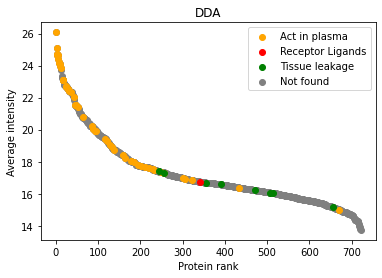

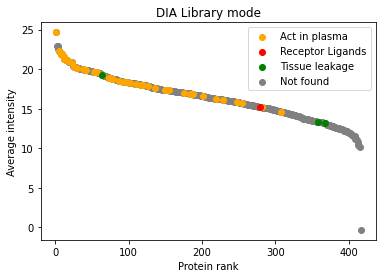

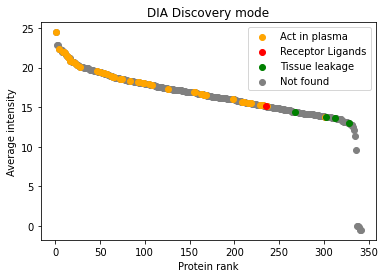

In [8]:
get_df_dda = get_table(df_dda)
get_df_dia_lib_mod = get_table(df_dia_lib_mod)
get_df_dia_disc_mod = get_table(df_dia_disc_mod)
table1 = pd.read_table('annotation.txt', delimiter = "\t", dtype = str)
intensity_dda = table_parser(table1,get_df_dda)
intensity_dia_lib_mod = table_parser(table1,get_df_dia_lib_mod)
intensity_dia_disc_mod = table_parser(table1,get_df_dia_disc_mod)

plot_biomarker(intensity_dda,'DDA', get_df_dda)
plot_biomarker(intensity_dia_lib_mod,'DIA Library mode', get_df_dia_lib_mod)
plot_biomarker(intensity_dia_disc_mod,'DIA Discovery mode', get_df_dia_disc_mod)